search started at: 2024-02-19 14:37:31.032930
search end at: 2024-02-19 14:37:31.034224
Total time --- 1.6413829326629639 seconds ---
{'10000001': 1024}


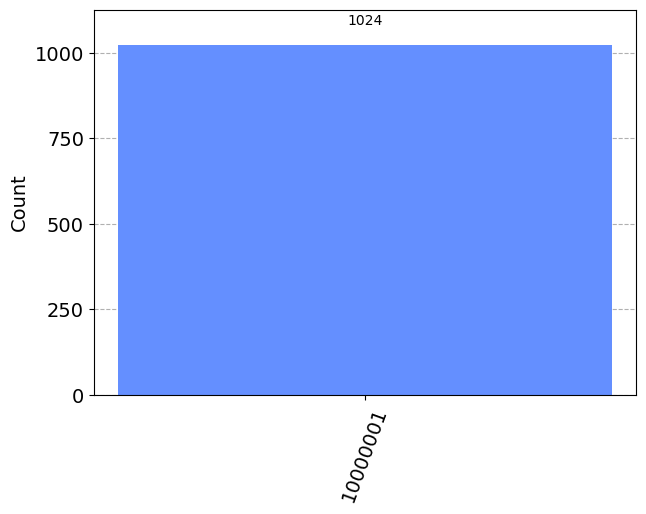

In [1]:
from qiskit import QuantumCircuit, Aer, execute, transpile
import math
from qiskit.visualization import plot_histogram
import time
from datetime import datetime

def partial_hadamard_transform(circuit, qubits_to_superpose):
    for qubit in qubits_to_superpose:
        circuit.h(qubit)

def partial_oracle(circuit, qubits, ancilla, target_state):
    for qubit, bit in zip(qubits, target_state):
        if bit == '0':
            circuit.x(qubit)
    circuit.mcx(qubits, ancilla)
    for qubit, bit in zip(qubits, target_state):
        if bit == '0':
            circuit.x(qubit)

def partial_diffuser(circuit, qubits_pair):
    if len(qubits_pair) == 1:
        circuit.z(qubits_pair[0])
    else:
        # For multiple qubits, use the existing implementation
        for qubit in qubits_pair:
            circuit.h(qubit)
            circuit.x(qubit)
        circuit.h(qubits_pair[-1])
        circuit.mcx(qubits_pair[:-1], qubits_pair[-1])
        circuit.h(qubits_pair[-1])
        for qubit in qubits_pair:
            circuit.x(qubit)
            circuit.h(qubit)

def iterative_grover_search(n, solution, p=2):
    print(f"search started at: {datetime.now()}")
    found_solutions = []
    ancilla = n
    circuit = QuantumCircuit(n + 1, n) 
    circuit.x(ancilla)
    circuit.h(ancilla)

    for step in range(0, n-1, p):
        qubits_to_superpose = list(range(step, min(step + p, n)))

        # Apply partial Hadamard transform
        partial_hadamard_transform(circuit, qubits_to_superpose)

        # Prepare the partial target state for the current segment
        partial_target_state = solution[step:step+p]
        
        # Apply the partial oracle
        partial_oracle(circuit, qubits_to_superpose, ancilla, partial_target_state)
        partial_diffuser(circuit, qubits_to_superpose)

        # Measure the qubits
        circuit.measure(qubits_to_superpose, qubits_to_superpose)
    
    if n % 2 != 0:
        if solution[-1] == '1':
            circuit.x(n-1)
        circuit.measure(n-1, n-1)
        
    print(f"search end at: {datetime.now()}")
    return circuit

start_time = time.time()

# Example usage
n=8
solution = '10000001'
circuit = iterative_grover_search(n, solution)

# Display the circuit

backend = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(circuit, backend)
result = backend.run(transpiled_circuit).result()
counts = result.get_counts()
print("Total time --- %s seconds ---" % (time.time() - start_time))
print(counts)
#print(circuit)
plot_histogram(counts)